# Variational Quantum Imaginary Time Evolution (VarQITE) for Combinatorial Problems

This notebook demonstrates the implementation of the Variational Quantum Imaginary Time Evolution (VarQITE) algorithm for solving combinatorial optimization problems, specifically the Max-Cut problem following the paper [Performant near-term quantum combinatorial optimization](https://arxiv.org/abs/2404.16135).

In [1]:
import random
from enum import Enum
from itertools import combinations
from typing import Callable, Dict, Tuple

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

from classiq import *

### Generate graph

In [2]:
def display_graph(G, weight_digits=2):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    digits = weight_digits
    formatted_labels = {edge: f"{weight:.{digits}f}" for edge, weight in labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels)
    plt.show()

In [3]:
class ProblemType(Enum):
    SK = "sk"
    NWS = "nws"
    REG3 = "reg3"

In [4]:
def nws(n: int) -> nx.Graph:
    """
    create a Newman-Watts-Strogatz graph with n nodes
    with k=4 and p=0.5, and weights chosen from (0, 1]
    """
    G = nx.newman_watts_strogatz_graph(n, k=4, p=0.5)
    for u, v in G.edges():
        # assign random weights to edges in the range (0, 1]
        weight = 1.0 - random.random()
        G.edges[u, v]["weight"] = weight
    G.problem_type = ProblemType.NWS
    return G

In [5]:
G = nws(4)

In [6]:
print(G)

Graph with 4 nodes and 6 edges


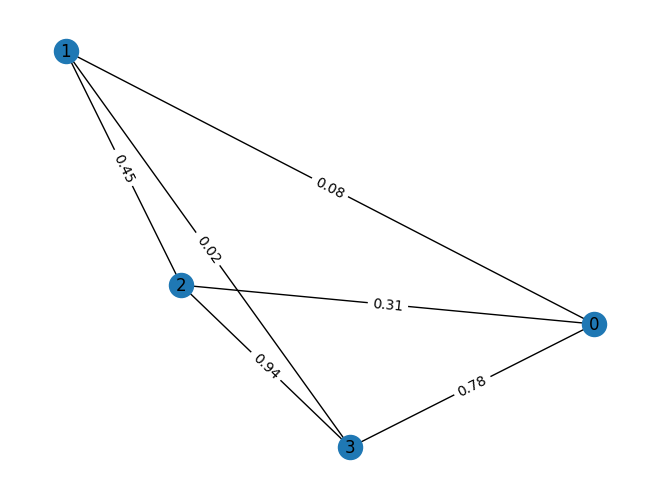

In [7]:
display_graph(G)

## Generate ansatz

In [8]:
def vertex_weight(G: nx.Graph) -> Dict[int, int]:
    """
    calculate the vertex weight of a graph

    Args:
        G (nx.Graph): The input graph.

    Returns:
        dict: A dictionary containing the vertex weights.
    """
    rho = {}
    for u, v in G.edges():
        weight = abs(G.edges[u, v]["weight"])
        for node in (u, v):
            if node not in rho:
                rho[node] = 0
            rho[node] += weight
    return rho

In [9]:
def graph_to_ansatz_rotations(G: nx.Graph, all_nodes=True) -> list[list[Pauli]]:
    """
    Given a graph G, return a list of Pauli strings corresponding to the edges of the graph, or all nodes if all_nodes is True.
    Each Pauli string is represented as a Y-Z string on each pair of nodes.
    The list of Pauli strings is sorted by the vertex weight of the nodes in the graph.
    """
    minmax = lambda x: (min(x), max(x))
    pauli_strings = []

    if all_nodes:
        node_pairs = combinations(G.nodes(), 2)
    else:
        node_pairs = G.edges()

    # sort the node pairs by their vertex weight
    vw = vertex_weight(G)
    node_pairs = sorted(node_pairs, key=lambda pair: minmax((vw[pair[0]], vw[pair[1]])))

    # build the Pauli strings
    for i, j in node_pairs:
        if vw[i] < vw[j]:
            n1, n2 = i, j
        else:
            n1, n2 = j, i
        pauli_string = []
        for n in G.nodes():
            if n == n1:
                pauli_string.append(Pauli.Z)
            elif n == n2:
                pauli_string.append(Pauli.Y)
            else:
                pauli_string.append(Pauli.I)
        pauli_strings.append(pauli_string)
    return pauli_strings

Given a graph G, return a quantum circuit for the maxcut problem. The circuit consists of single-qubit Hadamard gates, followed by a series of two-qubit `Pauli` `(Y-Z)` rotations. The two-qubit rotations are parameterized by angles, which are the variational parameters of the ansatz.

In [10]:
@qfunc
def maxcut_ansatz(
    two_qubit_pauli_rotations: CArray[CArray[Pauli]],
    angles: CArray[CReal],
    nodes: Output[QArray[QBit]],
) -> None:
    """
    Generate a counteradiabatic-inspired variational quantum circuit for combinatorial optimization problems.
    The circuit consists of single-qubit Hadamard gates, followed by a series of two-qubit Pauli (Y-Z) rotations.
    The two-qubit rotations are parameterized by angles, which are the variational parameters of the ansatz.
    Arguments:
        two_qubit_pauli_rotations (CArray[CArray[Pauli]]): The two-qubit Pauli rotations.
        angles (CArray[CReal]): The angles for the two-qubit rotations.
        nodes (Output[QArray[QBit]]): The output quantum register.
    """
    num_qubits = len(two_qubit_pauli_rotations[0])
    allocate(num_qubits, nodes)

    hadamard_transform(nodes)

    for ps, angle in zip(two_qubit_pauli_rotations, angles):
        single_pauli_exponent(pauli_string=ps, coefficient=angle, qbv=nodes)

In [11]:
two_qubit_pauli_rotations = graph_to_ansatz_rotations(G)

V = len(G.nodes)
NUM_ANGLES = (V * (V - 1)) // 2

In [12]:
len(two_qubit_pauli_rotations)

6

In [13]:
@qfunc
def main(nodes: Output[QArray[QBit]], angles: CArray[CReal, NUM_ANGLES]) -> None:
    """
    Main function to generate the quantum circuit for the maxcut problem.
    captures the ansatz rotations, using the `maxcut_ansatz` quantum function.
    Arguments:
        nodes (Output[QArray[QBit]]): The output quantum register.
        angles (CArray[CReal, NUM_ANGLES]): The angles for the two-qubit rotations.
    """
    num_qubits = len(two_qubit_pauli_rotations[0])
    allocate(num_qubits, nodes)

    hadamard_transform(nodes)

    # for ps, angle in zip(two_qubit_pauli_rotations, angles):
    #     single_pauli_exponent(pauli_string=ps, coefficient=angle, qbv=nodes)

    for ind in range(len(two_qubit_pauli_rotations)):
        single_pauli_exponent(
            pauli_string=two_qubit_pauli_rotations[ind],
            coefficient=angles[ind],
            qbv=nodes,
        )
    # maxcut_ansatz(two_qubit_pauli_rotations, angles, nodes)

In [14]:
write_qmod(main, "variational_quantum_imaginary_time_evolution")
qprog = synthesize(main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36qGJrCbEFP0cr6wcXz1NY3kP20


## Var-IT Optimization
### Ansatz
The quantum circuit has one qubit for each node in the graph. All qubits are initialized to the $|+\rangle$ state. Subsequently, each pair of nodes in the graph is rotated by a $Y\text{--}Z$ rotation, $R_{YZ}\left(\theta_j\right)$.
For a graph with $V$ nodes, there are $N_p = V(V-1)/2$ pairs, giving $N_p$ parametric angles.
### Cost Function
Representing the Max-Cut cost hamiltonian as a sum of Paulis:
$$H_c=\sum_{\alpha} P_\alpha, \quad H_c|z\rangle=C(z)|z\rangle$$
Where the cost is defined either by the physics convention:
$$C(z)=\sum_{(i,j)\in E} w_{ij} z_i z_j \quad z_i\in\{1,-1\}$$
or the computer science convention:
$$C(z)=-\sum_{(i,j)\in E} w_{ij}\left(z_i + z_j - 2 z_i z_j\right)/2 \quad z_i\in\{0,1\}$$
### Parameter Optimization
The parametric angles are updated by solving the linear equation:
$$G\cdot\dot{\vec{\theta}}=D$$
and updating the angles: $\vec{\theta}\rightarrow\vec{\theta}+\Delta\tau\dot{\vec{\theta}}$
The matrix $G$, and vector $D$, are defined as:
$$ G_{\alpha,j}= \Re \left(\langle\Psi\left(\vec{\theta}\right)|P_\alpha\frac{\partial |\Psi\left(\vec{\theta}\right)\rangle}{\partial \theta_j} \right)$$
$$D_\alpha=-\frac{1}{2}\langle\Psi\left(\vec{\theta}\right)| \{P_\alpha, H_c-E_\tau\} |\Psi\left(\vec{\theta}\right)\rangle$$
where $P_\alpha$ is one of the Pauli strings that make up the cost Hamiltonian, $H_c$ is the entire cost Hamiltonian, and $E_\tau$ is the previous value of the cost Hamiltonian

In [15]:
class CostConvention(Enum):
    PHYSICS = "physics"
    CS = "computer science"


Graph_Cost_Convention = {
    ProblemType.SK: CostConvention.PHYSICS,
    ProblemType.NWS: CostConvention.CS,
    ProblemType.REG3: CostConvention.CS,
}

In [16]:
def graph_to_hamiltonian(graph: nx.Graph) -> list[PauliTerm]:
    """
    Calculate the Hamiltonian of a graph, using the Physics or CS convention.
    The Hamiltonian is a weighted sum of Pauli strings.

    Args:
        graph (nx.Graph): The input graph.

    Returns:
        list[PauliTerm]: The Hamiltonian as a list of Pauli strings and weights.
    """

    # The Hamiltonian for the Physics convention is:
    # H = sum_{(i,j) \in E} (w_{ij} Z_i Z_j)
    # and for the CS convention is:
    # H = -sum_{(i,j) \in E} (w_{ij}(1 - Z_i Z_j))/2

    assert hasattr(graph, "problem_type"), "Graph has no problem type"
    assert (
        graph.problem_type in Graph_Cost_Convention
    ), "The problem type is not supported"

    convention = Graph_Cost_Convention[graph.problem_type]

    H = []
    sum_of_weights = 0
    num_nodes = len(graph.nodes)

    for u, v in graph.edges:
        weight = graph.edges[u, v]["weight"]
        sum_of_weights += weight
        pauli = []
        for n in graph.nodes:
            if n == u or n == v:
                pauli.append(Pauli.Z)
            else:
                pauli.append(Pauli.I)
        H.append(PauliTerm(pauli=pauli, coefficient=weight))
    if convention == CostConvention.CS:
        # Convert the Hamiltonian from the Physics to the CS convention
        H = [PauliTerm(pt.pauli, pt.coefficient / 2) for pt in H]
        H.append(
            PauliTerm(pauli=[Pauli.I] * num_nodes, coefficient=-sum_of_weights / 2)
        )
    return H

In [17]:
# type alias for the measure statistics
# the statistics are a list of tuples, where each tuple contains the state of the output quantum register
# and the number of shots for that state
measure_stats_t = list[Tuple[list[int], int]]


def z_output_measurements(
    qprog: QuantumProgram,
    output_qreg: str,
    num_shots: int = 128,
    param_vals: Dict[str, list[float]] = None,
) -> Tuple[list[float], measure_stats_t]:
    """
    Calculate the Z output measurements of a quantum circuit given a `quantum program`,
    and a set of parameters.
    The Z output measurements are the expectation values of the Z operator
    for each qubit in the output quantum register.
    For each zero measurement, the output is incremented by the number of shots,
    and for each one measurement, the output is decremented by the number of shots.
    The final output is normalized by the number of shots.
    Args:
        qprog (SerializedQuantumProgram): The quantum program to be executed.
        output_qreg (str): The quantum register to be measured.
        num_shots (int, optional): The number of shots for the execution. Defaults to 128.
        backend (BackendPreferencesTypes, optional): The backend preferences for the execution. Defaults to None, executed on the local simulator.
        param_vals (Dict[str, list[float]], optional): The parameter values for the quantum program. Defaults to None.
    Returns:
        list[float]: The expectation of the Z output measurements of the output qubits.
        list[Tuple[list[int], int]]: The statistics of the Z output measurements.
    The statistics are a list of tuples, where each tuple contains the state of the output quantum register
    and the number of shots for that state.
    """
    with ExecutionSession(
        quantum_program=qprog,
        execution_preferences=ExecutionPreferences(num_shots=num_shots),
    ) as es:
        if param_vals:
            sample_result = es.sample(param_vals)
        else:
            sample_result = es.sample()

    parsed_counts = sample_result.parsed_counts_of_outputs(output_qreg)
    num_shots = sample_result.num_shots
    num_qubits = len(parsed_counts[0].state[output_qreg])

    expectation = [0] * num_qubits

    statistics = []

    for parsed_count in parsed_counts:
        # each `parsed_count` contains the state of the output quantum register
        # and the number of shots for that state
        # the state is a list of 0s and 1s, where 0 means the qubit is in the |0> state
        # and 1 means the qubit is in the |1> state
        state = parsed_count.state[output_qreg]
        shots = parsed_count.shots
        statistics.append((state, shots))
        for idx, s in enumerate(state):
            if s == 0:
                expectation[idx] += shots
            else:
                expectation[idx] -= shots

    expectation = [x / num_shots for x in expectation]

    return expectation, statistics


def pauli_term_expectation(statistics: measure_stats_t, pauli_term: PauliTerm):
    """
    Calculate the expectation value of a Pauli term given a set of statistics.
    The statistics are a list of tuples, where each tuple contains the state of the output quantum register
    and the number of shots for that state.
    The Pauli term is a weighted sum of Pauli strings.
    The expectation value is calculated by summing the parity of the state and the probability of the state,
    and then multiplying by the parity sign.
    NOTE: currently, only Z (and I) terms are supported.
    Args:
        statistics (list[Tuple[list[int], int]]): The statistics of the Z output measurements.
        pauli_term (PauliTerm): The Pauli term to be estimated.
    Returns:
        float: The expectation value of the Pauli term.
    """
    assert statistics, "Statistics list is empty."
    assert pauli_term.pauli, "Pauli term is empty."

    expectation = 0
    num_shots = sum([shots for _, shots in statistics])
    for state, shots in statistics:
        prob = shots / num_shots
        parity_sign = 1
        for idx, pauli in enumerate(pauli_term.pauli):
            if pauli == Pauli.Z and state[idx] == 1:
                parity_sign *= -1
        expectation += parity_sign * prob

    return expectation


def G_mat(
    ansatz: QuantumProgram, thetas: list[float], hamiltonian: list[PauliTerm]
) -> np.array:
    """
    Calculate the G matrix from equation (7) in the paper.
    The matrix elements G_alpha,j are defined as the expectation value of the Pauli term P_alpha
    with respect to the gradient of the ansatz with respect to the j-th angle.
    The gradient is calculate using the parameter shift rule:
    G_alpha,j = 1/4 * (<Psi(theta + pi/4)|P_alpha| - Psi(theta + pi/4)> -
    <Psi(theta - pi/4)|P_alpha|Psi(theta - pi/4)>)
    where |Psi(theta)> is the state of the ansatz with the angles theta.
    """
    assert hamiltonian, "Hamiltonian is empty."
    num_of_paulis = len(hamiltonian)
    num_of_nodes = len(hamiltonian[0].pauli)
    num_of_angles = (num_of_nodes * (num_of_nodes - 1)) // 2
    assert (
        len(thetas) == num_of_angles
    ), "number of angles is not equal to the number of pairs of nodes"

    G = np.zeros((num_of_paulis, num_of_angles))

    for j, theta in enumerate(thetas):
        thetas[j] = theta + np.pi / 4
        _, measure_stats_p = z_output_measurements(
            qprog=ansatz, output_qreg="nodes", param_vals={"angles": thetas}
        )
        thetas[j] = theta - np.pi / 4
        _, measure_stats_m = z_output_measurements(
            qprog=ansatz, output_qreg="nodes", param_vals={"angles": thetas}
        )
        thetas[j] = theta

        for alpha, pauli_term in enumerate(hamiltonian):
            G[alpha, j] = (
                pauli_term_expectation(measure_stats_p, pauli_term)
                - pauli_term_expectation(measure_stats_m, pauli_term)
            ) / 4

    return G


def state_pauli_eval(state: list[int], pauli_term: PauliTerm) -> float:
    """
    Evaluate the expectation of a Pauli string for a given a state.
    The state is a list of 0s and 1s, where 0 means the qubit is in the |0> state
    and 1 means the qubit is in the |1> state.
    The Pauli string is given by the `pauli` field of the PauliTerm class,
    ignoring the `coefficient` field.
    The function wraps the given state to create a `measure_stats_t` object,
    and then calls the `pauli_term_expectation` function to calculate the expectation value.
    NOTE: currently, only Z (and I) terms are supported in the Pauli string.
    Args:
        state (list[int]): The state of the output quantum register.
        pauli_term (PauliTerm): The Pauli term to be evaluated.
    Returns:
        float: The evaluation of the Pauli term.
    """
    ms = [(state, 1)]
    return pauli_term_expectation(ms, pauli_term)


def operator_expectation(
    f_state: Callable[[list[int]], float], statistics: measure_stats_t
) -> float:
    """
    Calculate the expectation value of an operator given a set of statistics.
    The operator is defined by the function `f_state`, which takes a state as input
    and returns a float value. This provides the flexibility to define any operator.
    The statistics are a list of tuples, where each tuple contains the state of the output quantum register
    and the number of shots for that state.
    The expectation value is calculated by summing the operator value times the probability for each state.
    Args:
        f_state (Callable[[list[int]], float]): The operator function to be evaluated.
        statistics (list[Tuple[list[int], int]]): The statistics of the Z output measurements.
    Returns:
        float: The expectation value of the operator.
    """
    assert statistics, "Statistics list is empty."

    expectation = 0
    num_shots = sum([shots for _, shots in statistics])
    for state, shots in statistics:
        prob = shots / num_shots
        expectation += f_state(state) * prob

    return expectation


def D_vec(
    ansatz: QuantumProgram,
    thetas: list[float],
    hamiltonian: list[PauliTerm],
    prev_energy: float,
) -> Tuple[np.array, float, float]:
    """
    Calculate the D vector from equation (8) in the paper.
    The equation can be rewritten as:
    D_alpha = <psi|E_tau P_alpha - H_c P_alpha|psi>
    which equals:
    D_alpha = <psi|E_tau P_alpha - sum_{beta} c_beta P_beta P_alpha|psi>

        where E_tau is the previous energy, P_alpha is the Pauli string for the alpha term,
        and c_alpha is the coefficient of the alpha term in the Hamiltonian.

    Args:
        ansatz (SerializedQuantumProgram): The ansatz circuit.
        thetas (list): The angles of the ansatz.
        hamiltonian (list): The Hamiltonian as a list of Pauli strings and weights.
        prev_energy (float): Previous Hc (energy) value
        sigma_0 (float): The standard deviation of the initial energy.
    Returns:
        np.array: The D vector.
        float: The expectation value of the f(H_c) operator, used as the next "prev_energy".
    """
    assert hamiltonian, "Hamiltonian is empty."

    H_c = lambda state: sum(
        state_pauli_eval(state, pauli_term) * pauli_term.coefficient
        for pauli_term in hamiltonian
    )
    # measure the circuit with the provided rotation angles
    # and calculate the standard deviation of the energy
    _, measure_stats = z_output_measurements(
        qprog=ansatz, output_qreg="nodes", param_vals={"angles": thetas}
    )
    num_of_paulis = len(hamiltonian)
    result = np.zeros(num_of_paulis)
    for alpha in range(num_of_paulis):
        P_alpha = lambda state: state_pauli_eval(state, hamiltonian[alpha])
        vec_el = lambda state: P_alpha(state) * (prev_energy - H_c(state))

        result[alpha] = operator_expectation(vec_el, measure_stats)

    return result, operator_expectation(H_c, measure_stats)


def solve_linear_system_with_svd_threshold(
    G: np.ndarray, D: np.ndarray, threshold_factor: float = 0.01
) -> np.ndarray:
    """
    Solves the linear system G @ dot_theta = D using SVD and discards
    singular values below a threshold.

    Args:
        G (np.ndarray): The G matrix.
        D (np.ndarray): The D vector.
        threshold_factor (float): The factor relative to the maximum singular
                                  value below which singular values are discarded.
                                  Defaults to 0.01.

    Returns:
        np.ndarray: The solution vector dot_theta.
    """
    U, s, Vt = np.linalg.svd(G, full_matrices=False)
    max_s = s[0]  # s is sorted descending
    thresh = threshold_factor * max_s
    # Invert only the “large enough” singular values
    s_inv = np.array([1 / si if si >= thresh else 0.0 for si in s])
    G_pinv = Vt.T @ (s_inv[:, None] * U.T)

    # Solve for dot_theta
    dot_theta = G_pinv @ D

    return dot_theta


def hamiltonian_expectation_by_pauli_term(
    statistics: measure_stats_t,
    hamiltonian: list[PauliTerm],
) -> float:
    """
    Calculate the expectation value of a Hamiltonian given a set of statistics.
    The Hamiltonian is a weighted sum of Pauli strings.
    Args:
        statistics (list[Tuple[list[int], int]]): The statistics of the Z output measurements.
        hamiltonian (list[PauliTerm]): The Hamiltonian to be estimated.
    Returns:
        float: The expectation value of the Hamiltonian.
    """
    assert statistics, "Statistics list is empty."
    assert hamiltonian, "Hamiltonian is empty."

    expectation = 0
    for pauli_term in hamiltonian:
        expectation += (
            pauli_term_expectation(statistics, pauli_term) * pauli_term.coefficient
        )

    return expectation


def var_it_step(
    ansatz: QuantumProgram,
    thetas: list[float],
    hamiltonian: list[PauliTerm],
    prev_energy: float,
    delta_tau: float = 0.01,
) -> Tuple[list[float], float, float, Tuple[list[int], list[int]]]:
    """
    Update the angles of the ansatz using the D vector and G matrix.
    The update is done using the equation:
    dot_theta = G^-1 D
    where G is the G matrix and D is the D vector.
    Args:
        ansatz (SerializedQuantumProgram): The ansatz circuit.
        thetas (list): The angles of the ansatz.
        hamiltonian (list): The Hamiltonian as a list of Pauli strings and weights.
        prev_energy (float): Previous Hc (energy) value
        sigma_0 (float): The standard deviation of the initial energy.
        delta_tau (float): The step size for the update.
    Returns:
        list: The updated angles of the ansatz.
        float: The updated "prev_energy" of the ansatz.
        float: the updated expectation value of the Hamiltonian.
        tuple: node partitioning from truncation of the Z measurement of the ansatz.
    """
    assert hamiltonian, "Hamiltonian is empty."
    G = G_mat(ansatz, thetas, hamiltonian)
    D, energy = D_vec(ansatz, thetas, hamiltonian, prev_energy)

    dot_theta = solve_linear_system_with_svd_threshold(G, D)

    new_thetas = [
        theta + delta_tau * theta_grad for theta, theta_grad in zip(thetas, dot_theta)
    ]

    qubits, measure_stats = z_output_measurements(
        ansatz, "nodes", param_vals={"angles": thetas}
    )

    node_vals = [0 if qbit > 0 else 1 for qbit in qubits]
    node_idxs = range(len(qubits))
    par1 = []
    par2 = []
    for v, n in zip(node_vals, node_idxs):
        if v > 0:
            par1.append(n)
        else:
            par2.append(n)

    return (
        new_thetas,
        energy,
        hamiltonian_expectation_by_pauli_term(measure_stats, hamiltonian),
        (par1, par2),
    )

In [18]:
def maxcut_cost(G: nx.Graph, partition: Tuple[list, list]) -> float:
    """
    Calculate the cost of a maxcut partition.

    Args:
        G (nx.Graph): The input graph.
        partition (Tuple[list, list]): A tuple containing two partitions of the graph.

    Returns:
        float: The cost of the maxcut partition.
    """
    cut_size = 0
    physics_value = lambda x: 1 if x in partition[0] else -1
    cs_value = lambda x: 1 if x in partition[0] else 0
    physics_cost = lambda u, v: (
        G.edges[u, v]["weight"] * physics_value(u) * physics_value(v)
    )
    cs_cost = lambda u, v: (
        -G.edges[u, v]["weight"] * (0 if cs_value(u) == cs_value(v) else 1)
    )
    cost = (
        physics_cost
        if Graph_Cost_Convention[G.problem_type] == CostConvention.PHYSICS
        else cs_cost
    )

    for u, v in G.edges():

        if (u in partition[0] and v in partition[1]) or (
            u in partition[1] and v in partition[0]
        ):
            cut_size += cost(u, v)
    return cut_size

In [19]:
V = len(G.nodes)
NUM_ANGLES = (V * (V - 1)) // 2
rng = np.random.default_rng(seed=42)
thetas = [0.0] * NUM_ANGLES  # rng.random(NUM_ANGLES).tolist()
hamiltonian = graph_to_hamiltonian(G)

### VAR-IT optimization

In [20]:
delta_tau = 0.1
energy = 0.0
energies = []
maxcut_costs = []
for iter in range(1, 15):
    new_thetas, new_energy, h_exp, partition = var_it_step(
        ansatz=qprog,
        thetas=thetas,
        hamiltonian=hamiltonian,
        prev_energy=energy,
        delta_tau=delta_tau / np.sqrt(iter),
    )
    thetas = new_thetas
    energy = new_energy
    maxcut_cost_value = maxcut_cost(G, partition)
    energies.append(energy)
    maxcut_costs.append(maxcut_cost_value)
    print(
        f"iteration {iter}: energy = {energy:.3f}, <H> = {h_exp:.3f}, maxcut_cost = {maxcut_cost_value:.3f}"
    )

iteration 1: energy = -1.272, <H> = -1.200, maxcut_cost = -1.174
iteration 2: energy = -1.405, <H> = -1.519, maxcut_cost = -1.174
iteration 3: energy = -1.543, <H> = -1.597, maxcut_cost = -2.260
iteration 4: energy = -1.646, <H> = -1.545, maxcut_cost = -2.260
iteration 5: energy = -1.666, <H> = -1.571, maxcut_cost = -1.743
iteration 6: energy = -1.653, <H> = -1.683, maxcut_cost = -1.560
iteration 7: energy = -1.662, <H> = -1.722, maxcut_cost = -1.560
iteration 8: energy = -1.698, <H> = -1.730, maxcut_cost = -1.743
iteration 9: energy = -1.794, <H> = -1.788, maxcut_cost = 0.000
iteration 10: energy = -1.807, <H> = -1.814, maxcut_cost = -1.743
iteration 11: energy = -1.842, <H> = -1.788, maxcut_cost = -1.353
iteration 12: energy = -1.844, <H> = -1.797, maxcut_cost = -1.743
iteration 13: energy = -1.897, <H> = -1.817, maxcut_cost = -2.260
iteration 14: energy = -1.864, <H> = -1.864, maxcut_cost = -1.743


## Create a convergence figure

In [21]:
from itertools import chain, combinations


def solve_maxcut(G: nx.Graph) -> Tuple[int, Tuple[list, list]]:
    """
    Finds the maximum cut of a graph using brute force and itertools.

    Args:
        graph (nx.Graph): The input graph.

    Returns:
        tuple: A tuple containing the maximum cut size and the partition of nodes.
    """
    nodes = list(G.nodes())
    max_cut_size = 0
    best_partition = None

    for partition1 in chain.from_iterable(
        combinations(nodes, r) for r in range(1, len(nodes))
    ):
        partition2 = [node for node in nodes if node not in partition1]
        cut_size = 0
        for u, v in G.edges():
            if (u in partition1 and v in partition2) or (
                u in partition2 and v in partition1
            ):
                cut_size += G.edges[u, v]["weight"]
                # change to 1 for unweighted maxcut

        if cut_size > max_cut_size:
            max_cut_size = cut_size
            best_partition = (list(partition1), partition2)

    return max_cut_size, best_partition

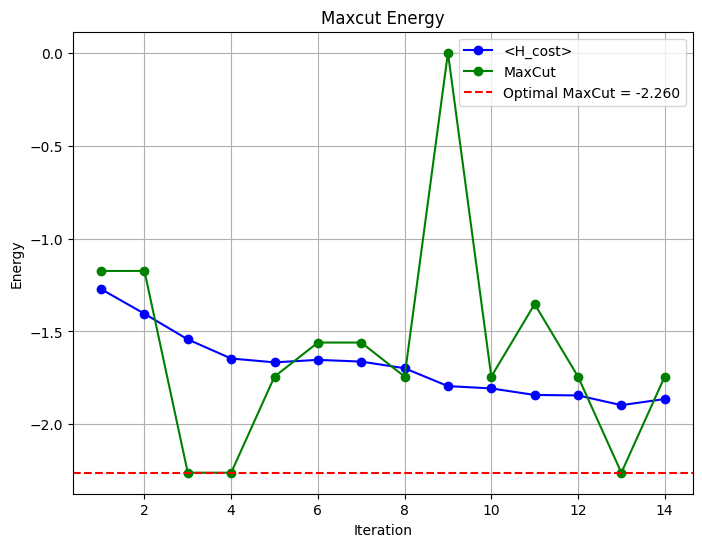

In [22]:
plt.figure(figsize=(8, 6))
maxcut_val, _ = solve_maxcut(G)
plt.plot(
    list(range(1, len(energies) + 1)),
    energies,
    marker="o",
    linestyle="-",
    color="b",
    label="<H_cost>",
)
plt.plot(
    list(range(1, len(energies) + 1)),
    maxcut_costs,
    marker="o",
    linestyle="-",
    color="g",
    label="MaxCut",
)
plt.axhline(
    y=-maxcut_val,
    color="r",
    linestyle="--",
    label=f"Optimal MaxCut = {-maxcut_val:.3f}",
)
plt.title("Maxcut Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend()
plt.grid(True)
plt.show()